# Google Colab demo

To enable GPU:
Runtime -> Change runtime type -> GPU

In [11]:
! pip install onnxruntime
! pip install openvino
! pip install huggingface_hub

! git clone https://github.com/ai-forever/SEGM-model.git

fatal: destination path 'SEGM-model' already exists and is not an empty directory.


In [12]:
# !pip cache purge
# !python -m pip install --upgrade pip
# !python -m pip install --upgrade setuptools
# !pip3 install wheel setuptools pip --upgrade
# !pip install numpy --use-deprecated=legacy-resolver

Files removed: 76


In [13]:
import sys
sys.path.append('SEGM-model/')

#!pip install -r SEGM-model/requirements.txt

import cv2
from matplotlib import pyplot as plt
import numpy as np

from huggingface_hub import hf_hub_download

from segm.predictor import SegmPredictor

In [166]:
repo_id = "ai-forever/ReadingPipeline-notebooks"

# IMG_PATH = "/content/download (1).png"
IMG_PATH = "/content/line_2.jpg"
# IMG_PATH ="/content/Screenshot from 2024-04-10 18-17-28.jpg"

MODEL_PATH = hf_hub_download(repo_id, "segm/segm_model.ckpt")
CONFIG_PATH = hf_hub_download(repo_id, "segm/segm_config.json")

NUM_THREADS = 8

DEVICE = 'cuda'

RUNTIME = 'Pytorch'

In [167]:
predictor = SegmPredictor(
    model_path=MODEL_PATH,
    config_path=CONFIG_PATH,
    num_threads=NUM_THREADS,
    device=DEVICE,
    runtime=RUNTIME
)

In [168]:
image = cv2.imread(IMG_PATH)

pred_data = predictor([image])

In [169]:
def find_contours(img, to_gray=None):
    kernel   = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    morphed  = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
    contours = cv2.findContours(morphed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours[-2]

In [170]:
def mask_from_contours(ref_img, contours):
    mask = np.zeros(ref_img.shape, np.uint8)
    mask = cv2.drawContours(mask, contours, -1, (255,255,255), -1)
    return cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

In [171]:
def dilate_mask(mask, kernel_size=10):
    kernel  = np.ones((kernel_size,kernel_size), np.uint8)
    dilated = cv2.dilate(mask, kernel, iterations=1)
    return dilated

In [172]:
def sort_contours(cnts, method="left-to-right"):
	# initialize the reverse flag and sort index
	reverse = False
	i = 0
	# handle if we need to sort in reverse
	if method == "right-to-left" or method == "bottom-to-top":
		reverse = True
	# handle if we are sorting against the y-coordinate rather than
	# the x-coordinate of the bounding box
	if method == "top-to-bottom" or method == "bottom-to-top":
		i = 1
	# construct the list of bounding boxes and sort them from top to
	# bottom
	boundingBoxes = [cv2.boundingRect(c) for c in cnts]
	(cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
		key=lambda b:b[1][i], reverse=reverse))
	# return the list of sorted contours and bounding boxes
	return (cnts, boundingBoxes)

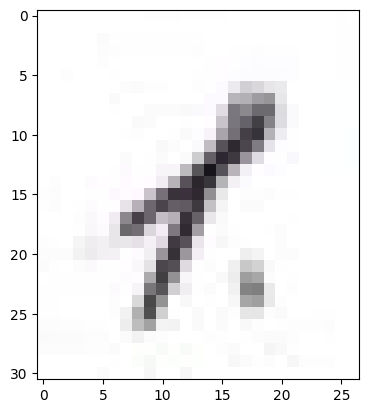

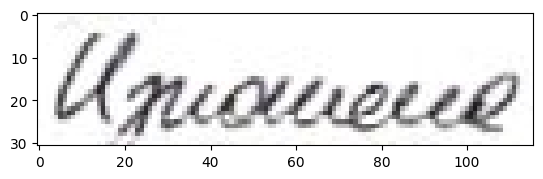

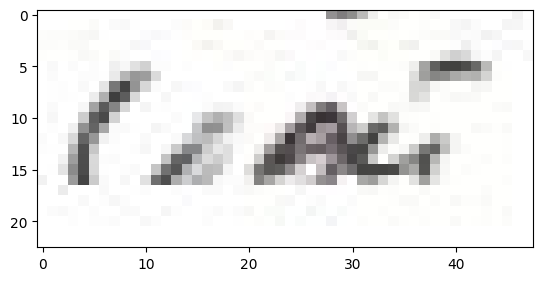

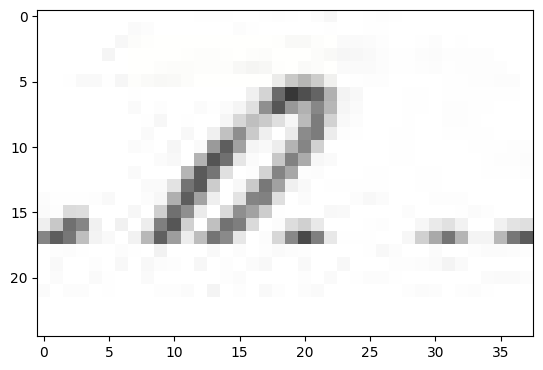

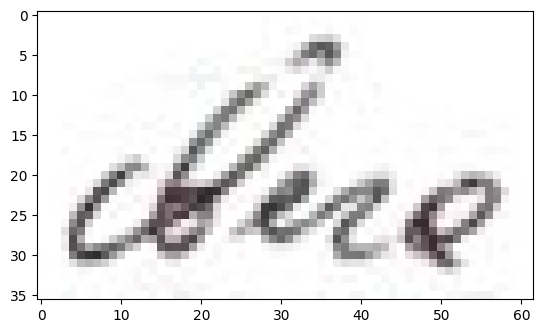

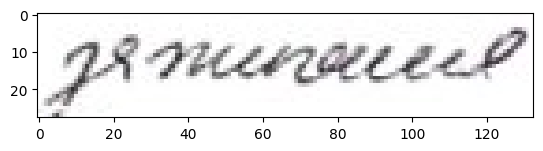

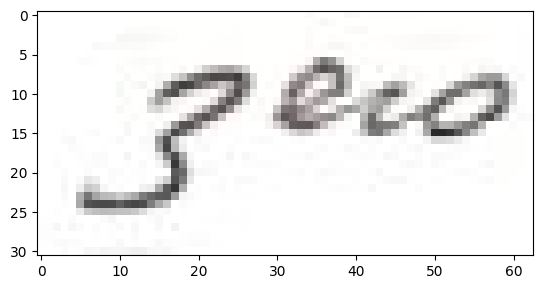

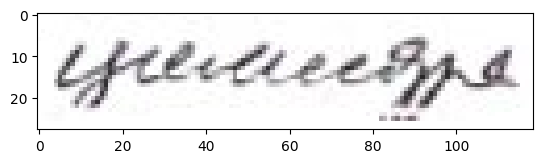

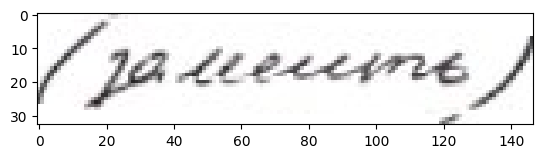

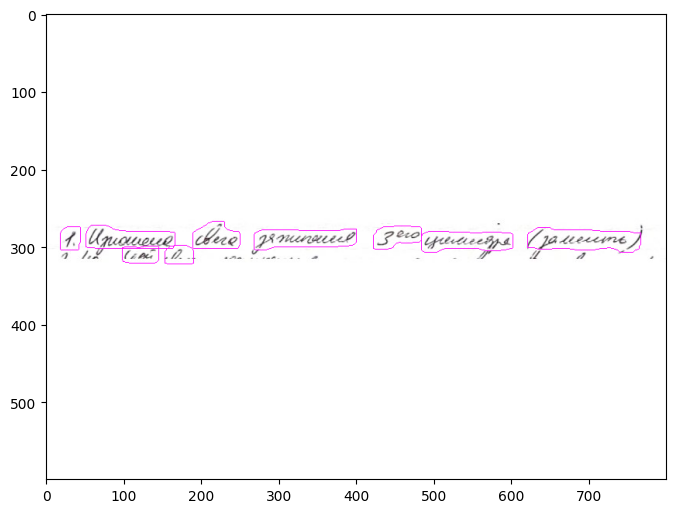

In [173]:
pred_img = pred_data[0]

image = cv2.imread(IMG_PATH)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
show = image.copy()
cnts = []
for prediction in pred_img['predictions']:
    if prediction['class_name'] == 'shrinked_text':
      cnts.append(np.array(prediction['polygon'][::-1]))
contours = sort_contours(cnts)

for contour in contours[0]:
    mask = mask_from_contours(image.copy(), [contour])
    expanded = dilate_mask(mask, 15)
    expanded_contour = find_contours(expanded)
    result = image.copy()
    result = cv2.cvtColor(result, cv2.COLOR_BGR2BGRA)
    result[:, :, 3] = expanded
    x,y,w,h = cv2.boundingRect(expanded_contour[0])
    ROI = result[y:y+h, x:x+w]
    plt.imshow(ROI)
    plt.show()
    cv2.drawContours(show, expanded_contour, -1, (255, 0, 255), 1)

plt.figure(figsize=(8, 8))
plt.imshow(show)
plt.show()